<img src="https://devra.ai/analyst/notebook/3443/image.jpg" style="width: 100%; height: auto;" />

<div style="text-align:center; border-radius:15px; padding:15px; color:white; margin:0; font-family: 'Orbitron', sans-serif; background: #2E0249; background: #11001C; box-shadow: 0px 4px 8px rgba(0, 0, 0, 0.3); overflow:hidden; margin-bottom: 1em;"><div style="font-size:150%; color:#FEE100"><b>E-Commerce Customer Behavior Analysis</b></div><div>This notebook was created with the help of <a href="https://devra.ai/ref/kaggle" style="color:#6666FF">Devra AI</a></div></div>

# Introduction

There is an old saying in data science that every dataset has its own story. In this notebook, we analyze an e-commerce dataset that tracks customer behavior and sales. We will uncover insights into purchasing trends, explore customer demographics, and even create a simple predictor for returning customers. If you find the notebook useful, kindly upvote it.

## Table of Contents

- [Data Loading](#Data-Loading)
- [Data Cleaning and Preprocessing](#Data-Cleaning-and-Preprocessing)
- [Exploratory Data Analysis](#Exploratory-Data-Analysis)
- [Prediction Model: Returning Customer](#Prediction-Model)
- [Summary and Future Work](#Summary-and-Future-Work)

In [1]:
# Importing required libraries and suppressing warnings
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import matplotlib
matplotlib.use('Agg')  # Using non-interactive backend for matplotlib
import matplotlib.pyplot as plt
plt.switch_backend('Agg')  # Ensuring backend switching if only plt is imported
%matplotlib inline
import seaborn as sns

# Scikit-learn modules
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
from sklearn.inspection import permutation_importance

# Setting a seaborn style for better visualization aesthetics
sns.set(style="whitegrid")

In [2]:
# Data Loading
file_path = '/kaggle/input/e-commerce-customer-behavior-and-sales-analysis-tr/ecommerce_customer_behavior_dataset.csv'
df = pd.read_csv(file_path, encoding='ascii', delimiter=',')

# Displaying the first few rows of the dataset
df.head()

,Order_ID,Customer_ID,Date,Age,Gender,City,Product_Category,Unit_Price,Quantity,Discount_Amount,Total_Amount,Payment_Method,Device_Type,Session_Duration_Minutes,Pages_Viewed,Is_Returning_Customer,Delivery_Time_Days,Customer_Rating
0,ORD_001337,CUST_01337,2023-01-01,27,Female,Bursa,Toys,54.28,1,0.00,54.28,Debit Card,Mobile,4,14,True,8,5
1,ORD_004885,CUST_04885,2023-01-01,42,Male,Konya,Toys,244.90,1,0.00,244.90,Credit Card,Mobile,11,3,True,3,3
2,ORD_004507,CUST_04507,2023-01-01,43,Female,Ankara,Food,48.15,5,0.00,240.75,Credit Card,Mobile,7,8,True,5,2
3,ORD_000645,CUST_00645,2023-01-01,32,Male,Istanbul,Electronics,804.06,1,229.28,574.78,Credit Card,Mobile,8,10,False,1,4
4,ORD_000690,CUST_00690,2023-01-01,40,Female,Istanbul,Sports,755.61,5,0.00,3778.05,Cash on Delivery,Desktop,21,10,True,7,4


In [3]:
# Exploring the dataset
print('Dataset shape:', df.shape)
print('\nDataset info:')
df.info()

print('\nSummary statistics:')
df.describe()

Dataset shape: (5000, 18)

Dataset info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000 entries, 0 to 4999
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   Order_ID                  5000 non-null   object 
 1   Customer_ID               5000 non-null   object 
 2   Date                      5000 non-null   object 
 3   Age                       5000 non-null   int64  
 4   Gender                    5000 non-null   object 
 5   City                      5000 non-null   object 
 6   Product_Category          5000 non-null   object 
 7   Unit_Price                5000 non-null   float64
 8   Quantity                  5000 non-null   int64  
 9   Discount_Amount           5000 non-null   float64
 10  Total_Amount              5000 non-null   float64
 11  Payment_Method            5000 non-null   object 
 12  Device_Type               5000 non-null   object 
 13  Session_Duration_Minut

,Age,Unit_Price,Quantity,Discount_Amount,Total_Amount,Session_Duration_Minutes,Pages_Viewed,Delivery_Time_Days,Customer_Rating
count,5000.000000,5000.000000,5000.000000,5000.000000,5000.000000,5000.00000,5000.00000,5000.000000,5000.000000
mean,35.032600,455.834120,2.220000,24.852804,983.108914,14.57340,8.98420,6.497000,3.902800
std,11.080546,712.477209,1.398711,88.385124,1898.978528,8.66575,2.80434,3.464966,1.128542
min,18.000000,5.180000,1.000000,0.000000,7.870000,1.00000,1.00000,1.000000,1.000000
25%,27.000000,76.587500,1.000000,0.000000,122.517500,8.00000,7.00000,4.000000,3.000000
50%,35.000000,182.950000,2.000000,0.000000,337.910000,13.00000,9.00000,6.000000,4.000000
75%,42.000000,513.930000,3.000000,8.760000,979.695000,19.00000,11.00000,8.000000,5.000000
max,75.000000,7159.450000,5.000000,1525.550000,22023.900000,73.00000,24.00000,25.000000,5.000000


In [4]:
# Data Cleaning and Preprocessing

# Check for missing values
missing_values = df.isnull().sum()
print('Missing Values in each column:')
print(missing_values)

# Converting the 'Date' column to datetime format.
# Since the provided type is string, we attempt to infer the correct datetime structure.
df['Date'] = pd.to_datetime(df['Date'], errors='coerce')

# Verify conversion
print('\nData types after conversion:')
print(df.dtypes)

# It is always important to double-check for any rows that could not be converted
if df['Date'].isnull().sum() > 0:
    print('\nWarning: There are some rows with invalid dates. Consider handling these accordingly.')

# For demonstration, if needed we could drop or impute these rows
# df = df.dropna(subset=['Date'])

Missing Values in each column:
Order_ID                    0
Customer_ID                 0
Date                        0
Age                         0
Gender                      0
City                        0
Product_Category            0
Unit_Price                  0
Quantity                    0
Discount_Amount             0
Total_Amount                0
Payment_Method              0
Device_Type                 0
Session_Duration_Minutes    0
Pages_Viewed                0
Is_Returning_Customer       0
Delivery_Time_Days          0
Customer_Rating             0
dtype: int64

Data types after conversion:
Order_ID                            object
Customer_ID                         object
Date                        datetime64[ns]
Age                                  int64
Gender                              object
City                                object
Product_Category                    object
Unit_Price                         float64
Quantity                             int64

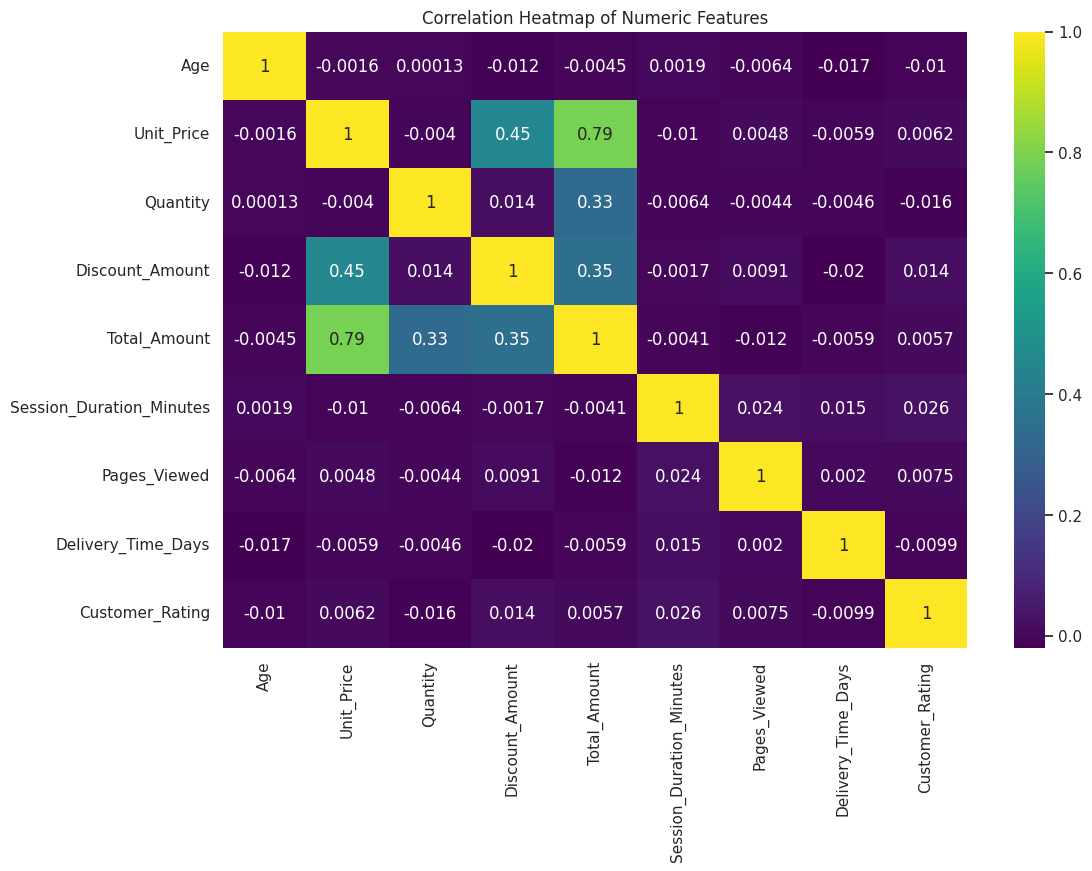

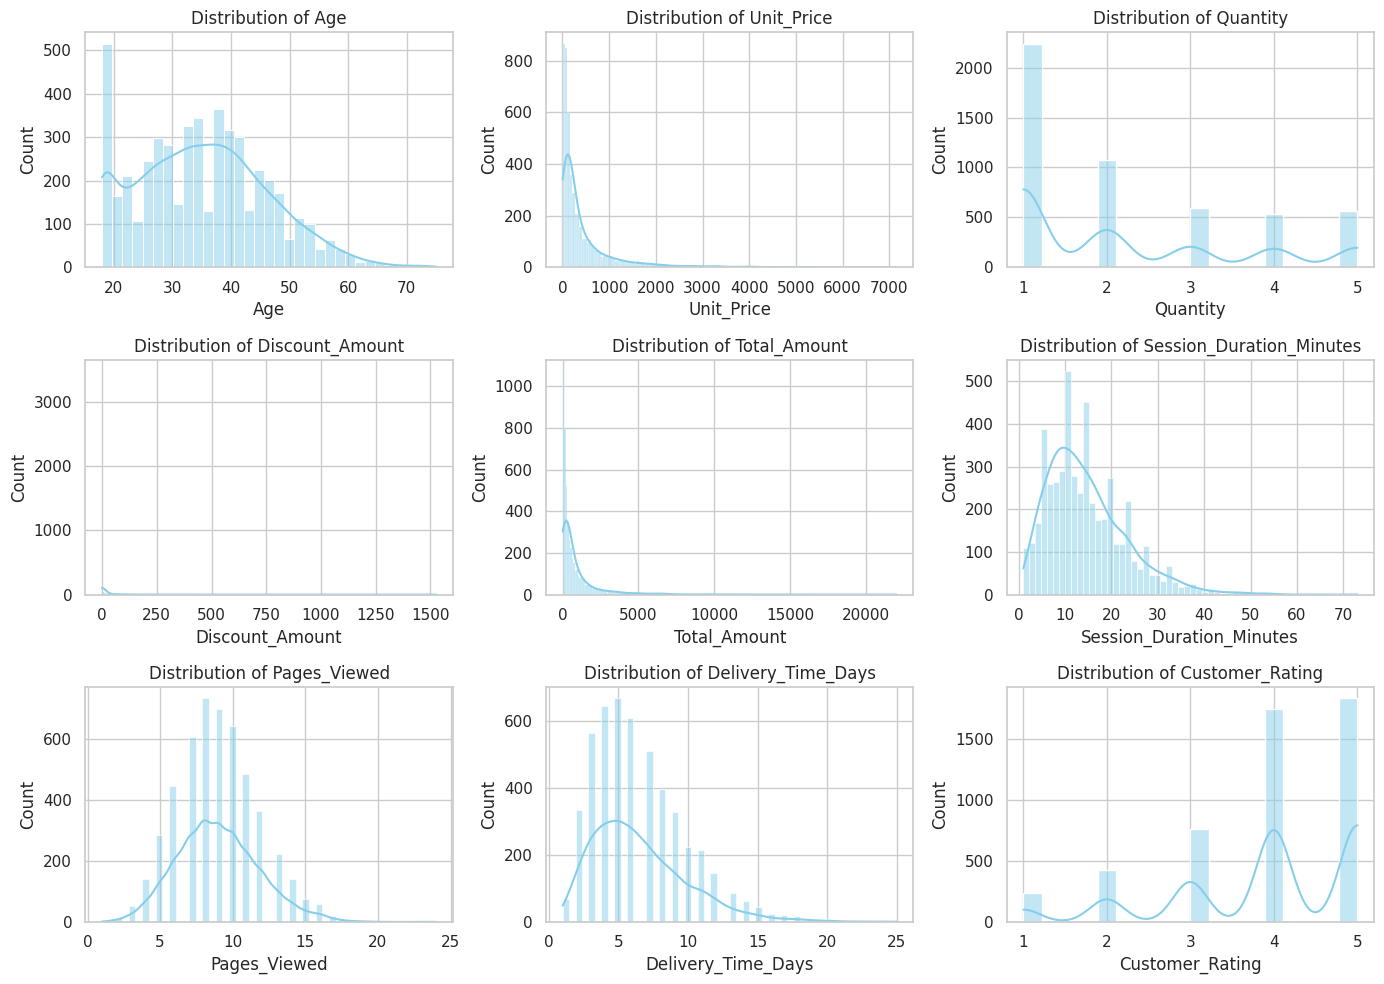

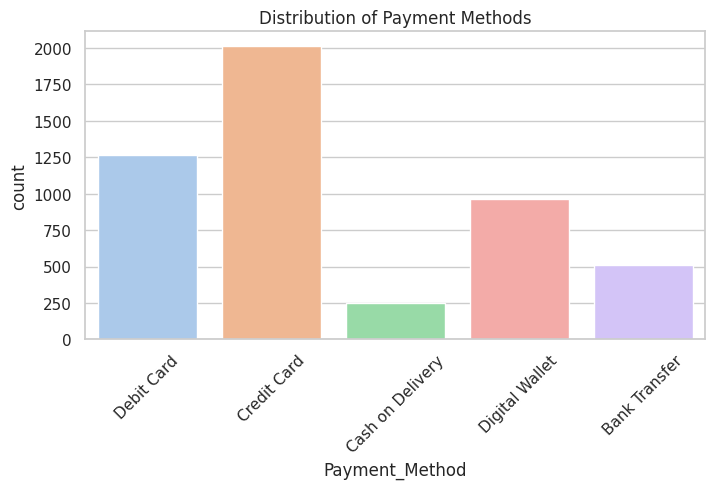

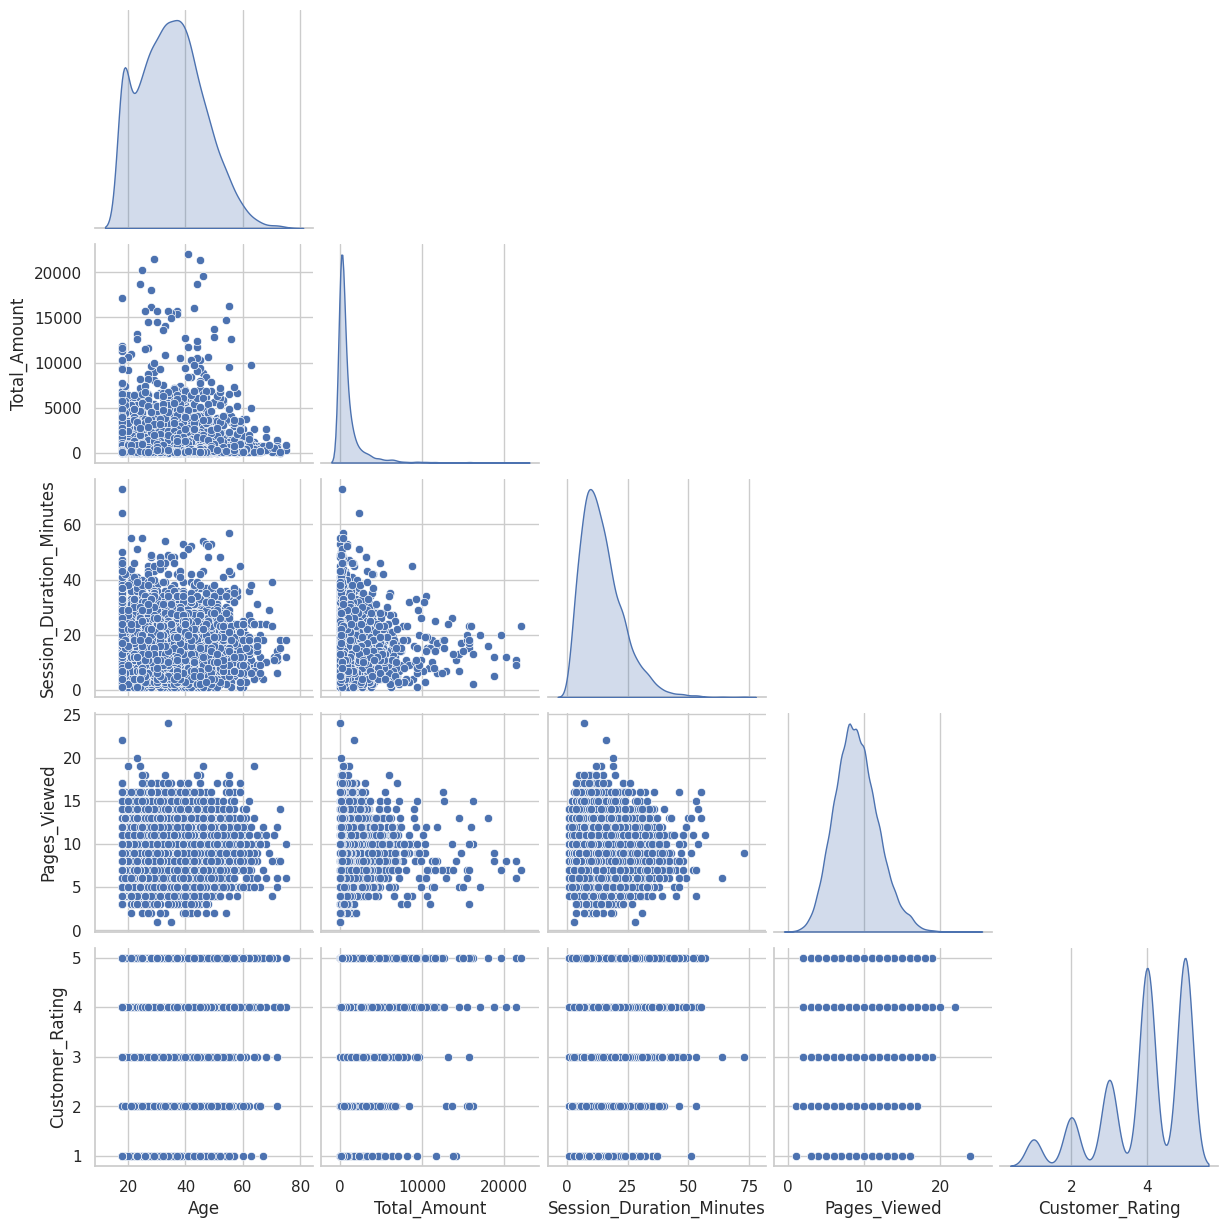

In [5]:
# Exploratory Data Analysis

# Let's examine the numeric features only for some analyses
numeric_df = df.select_dtypes(include=[np.number])

# If there are four or more numeric columns, display a correlation heatmap
if numeric_df.shape[1] >= 4:
    plt.figure(figsize=(12, 8))
    corr = numeric_df.corr()
    sns.heatmap(corr, annot=True, cmap='viridis')
    plt.title('Correlation Heatmap of Numeric Features')
    plt.show()
else:
    print('Not enough numeric columns to generate a correlation heatmap.')

# Plotting distributions for some key numeric variables
numeric_columns = ['Age', 'Unit_Price', 'Quantity', 'Discount_Amount', 'Total_Amount', 
                   'Session_Duration_Minutes', 'Pages_Viewed', 'Delivery_Time_Days', 'Customer_Rating']

plt.figure(figsize=(14, 10))
for i, col in enumerate(numeric_columns):
    plt.subplot(3, 3, i+1)
    sns.histplot(df[col].dropna(), kde=True, color='skyblue')
    plt.title(f'Distribution of {col}')
    plt.tight_layout()
plt.show()

# Count plot for categorical variable: Payment_Method
plt.figure(figsize=(8, 4))
sns.countplot(data=df, x='Payment_Method', palette='pastel')
plt.title('Distribution of Payment Methods')
plt.xticks(rotation=45)
plt.show()

# Pair plot for a subset of features to visually inspect relationships
subset_features = ['Age', 'Total_Amount', 'Session_Duration_Minutes', 'Pages_Viewed', 'Customer_Rating']
sns.pairplot(df[subset_features].dropna(), diag_kind='kde', corner=True)
plt.show()

Accuracy of the Returning Customer Predictor: 0.5933

Classification Report:
              precision    recall  f1-score   support

           0       0.00      0.00      0.00       610
           1       0.59      1.00      0.74       890

    accuracy                           0.59      1500
   macro avg       0.30      0.50      0.37      1500
weighted avg       0.35      0.59      0.44      1500



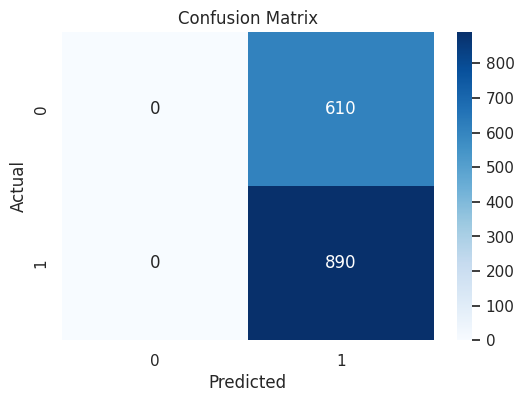

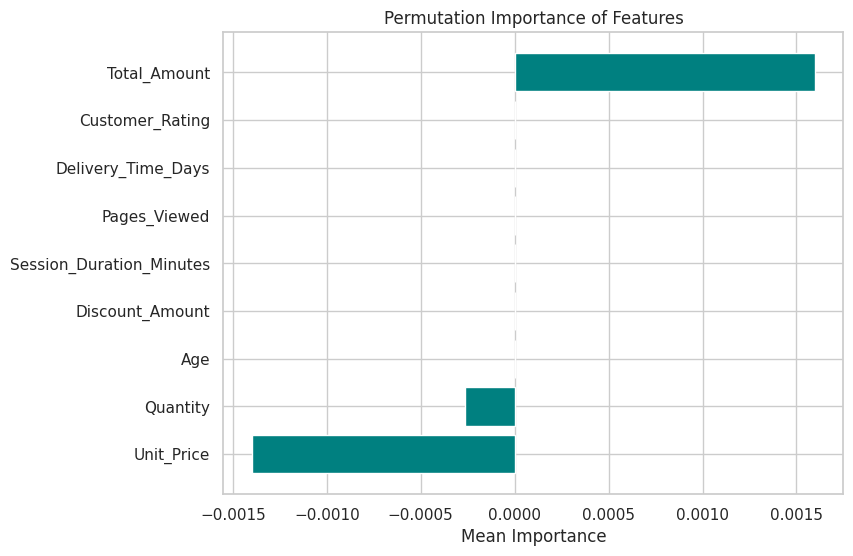

In [6]:
# Prediction Model: Returning Customer

# In this section, we will attempt to predict if a customer is returning based on
# other features of their session and purchasing behavior. Our target variable is 'Is_Returning_Customer'.

# For simplicity, we will use basic features; note that feature engineering could further improve the model.
# We will use a Logistic Regression classifier for this binary classification task.

# Preparing the data
features = ['Age', 'Unit_Price', 'Quantity', 'Discount_Amount', 'Total_Amount', 
            'Session_Duration_Minutes', 'Pages_Viewed', 'Delivery_Time_Days', 'Customer_Rating']

X = df[features].fillna(0)  # filling NA for numeric features with 0 for simplicity

# Converting the boolean target to integer (True -> 1, False -> 0)
y = df['Is_Returning_Customer'].astype(int)

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Initialize and train the Logistic Regression model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Making predictions
y_pred = model.predict(X_test)

# Evaluating the model performance using Accuracy Score
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy of the Returning Customer Predictor: {accuracy:.4f}")

# Displaying a detailed classification report
print('\nClassification Report:')
print(classification_report(y_test, y_pred))

# Creating a confusion matrix heatmap
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 4))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Calculating and plotting permutation importance
result = permutation_importance(model, X_test, y_test, n_repeats=10, random_state=42)
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': result.importances_mean
}).sort_values(by='Importance', ascending=True)

plt.figure(figsize=(8, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'], color='teal')
plt.title('Permutation Importance of Features')
plt.xlabel('Mean Importance')
plt.show()

# Summary and Future Work

This notebook explored an e-commerce dataset from multiple angles. We began with data cleaning and preprocessing – ensuring that the date information was appropriately converted and that missing values were handled. A variety of visualizations, including correlation heatmaps, pair plots, histograms, and count plots, were created to provide insights into the customer behavior and transaction details.

A prediction model was built to classify whether a customer is returning based on their session and purchase attributes. Although a logistic regression model was deployed here with modest accuracy, further improvements can be achieved with more rigorous feature engineering, hyperparameter tuning, and perhaps exploring other classifiers.

Future analysis could include segmentation of customers based on purchasing trends, time series analysis for seasonal product demand, and a deeper dive into the impact of discounts on the purchasing behavior.

If you found the notebook useful, please upvote it.